In [121]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set configuration

In [448]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg.copy_and_resolve_references()

#Set model specific config
n_hidden = 4
cfg.enc_hidden_dim = list(np.linspace(cfg.obs_dim,cfg.factor_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.dec_hidden_dim = list(np.linspace(cfg.factor_dim,cfg.obs_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.enc_activation = nn.Tanh
cfg.dec_activation = nn.Tanh
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = True

#set experiment specifig training params
cfg.lr = 0.0008
cfg.n_epoch = 50
cfg.max_iter = 10
cfg.saved_index = 17
cfg.use_default_data  = True
cfg.batch_size = 256

cfg.T_train = 100

## Obtain Data
Obtain the simulated $y$ and $f$

Theoretical optimal mse for f, y, enc: 0.052
Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Sigmoid()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Sigmoid()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Sigmoid()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Sigmoid()
  )
)
(100, 50) (1024, 50) (15260, 50)


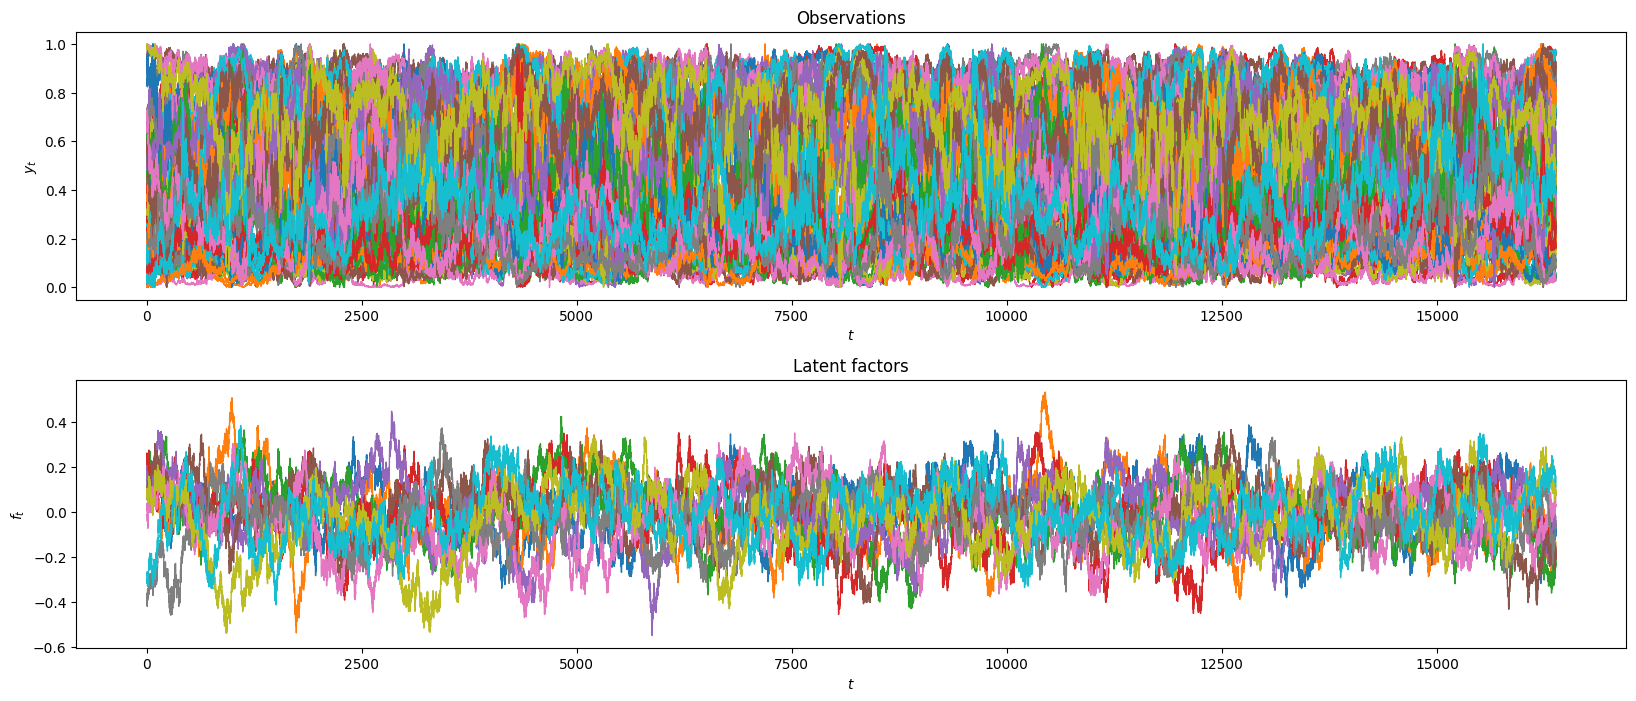

In [449]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=False, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [135]:
#torch.save(dec, '../DGP/saved/dec_5.pt')
#np.save(arr=y, file='../DGP/saved/y_5.npy')
#np.save(arr=f, file='../DGP/saved/f_5.npy')

## Estimate autoencoder model

In [473]:
n_hidden = 2
cfg.enc_hidden_dim = list(np.linspace(cfg.obs_dim,cfg.factor_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.dec_hidden_dim = list(np.linspace(cfg.factor_dim,cfg.obs_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.max_iter = 30
cfg.n_epoch = 10
cfg.lr = 0.0005
dec = Decoder(hidden_dim=cfg.dec_hidden_dim, activation=cfg.dec_activation, lastLayerLinear=cfg.dec_last_layer_linear)
enc = Encoder(hidden_dim=cfg.enc_hidden_dim, activation=cfg.enc_activation, lastLayerLinear=cfg.enc_last_layer_linear)
mod = AutoEncoder(enc=enc, dec=dec)
print(mod)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]

train_hist = trainMCMC(X_train=y_train, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter = cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")


/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Simulation/../BasicAutoEncoder/model.py:57: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


AutoEncoder(
  (enc): Encoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=50, out_features=36, bias=True)
      (activation_0): Tanh()
      (linear_1): Linear(in_features=36, out_features=23, bias=True)
      (activation_1): Tanh()
      (linear_2): Linear(in_features=23, out_features=10, bias=True)
      (activation_2): Tanh()
    )
  )
  (dec): Decoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=10, out_features=23, bias=True)
      (activation_0): Tanh()
      (linear_1): Linear(in_features=23, out_features=36, bias=True)
      (activation_1): Tanh()
      (linear_2): Linear(in_features=36, out_features=50, bias=True)
      (activation_2): Identity()
    )
  )
)
Number of trainable paramaters 5894
torch.Size([100, 50]) torch.Size([1024, 50])
1 1.201146125793457257934577
2 0.1676174849271774392717743
3 0.1247791275382042753820426
4 0.0864399522542953525429535
5 0.0547453425824642258246422
6 0.03113878145813942458139424
7 0.016653347760

In [478]:
EXPERIMENT_NAME = 'OverParametrization_T100'
logResults(train_hist, mod, cfg, EXPERIMENT_NAME)

./Results/17/2_OverParametrization_T100_05152023_01:01:26


### Train & val loss

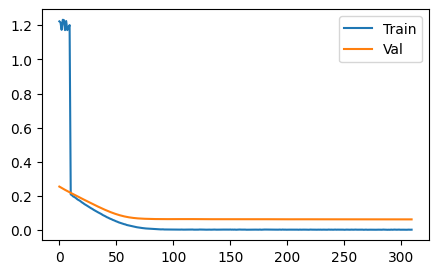

In [474]:
plot_train_hist(train_hist, log=False)

### Convergence of mu of epsilon

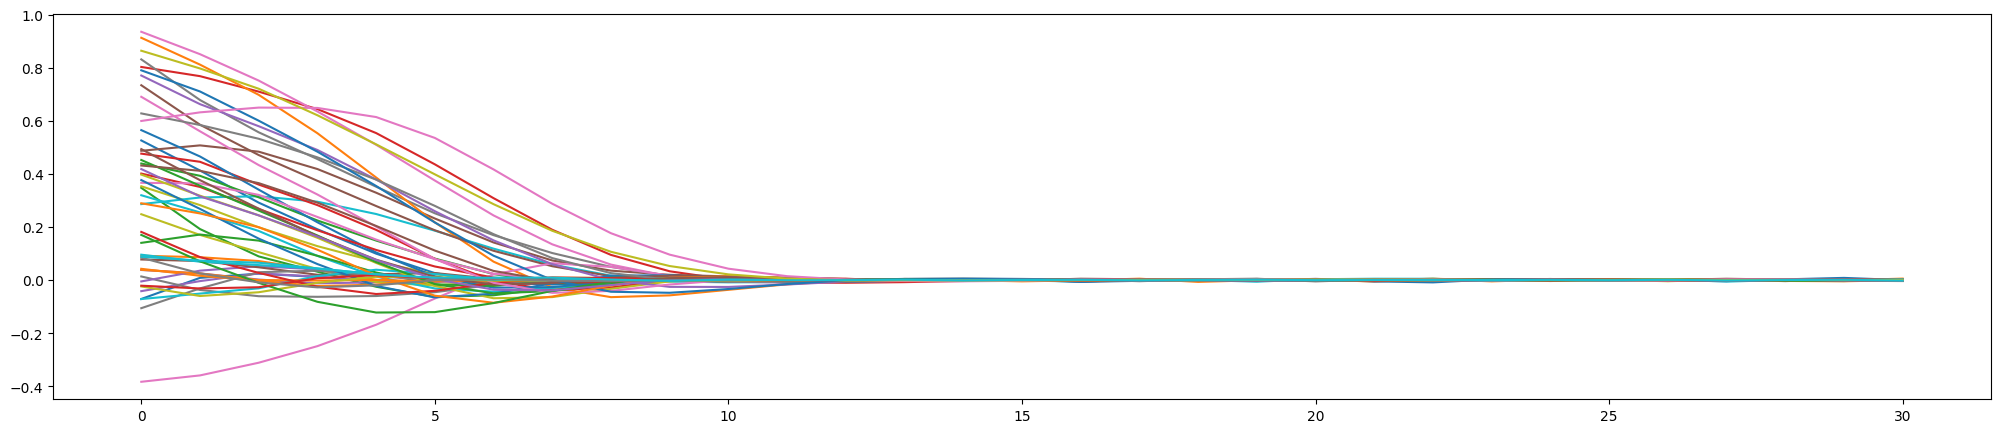

In [475]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

### Reconstruction of y

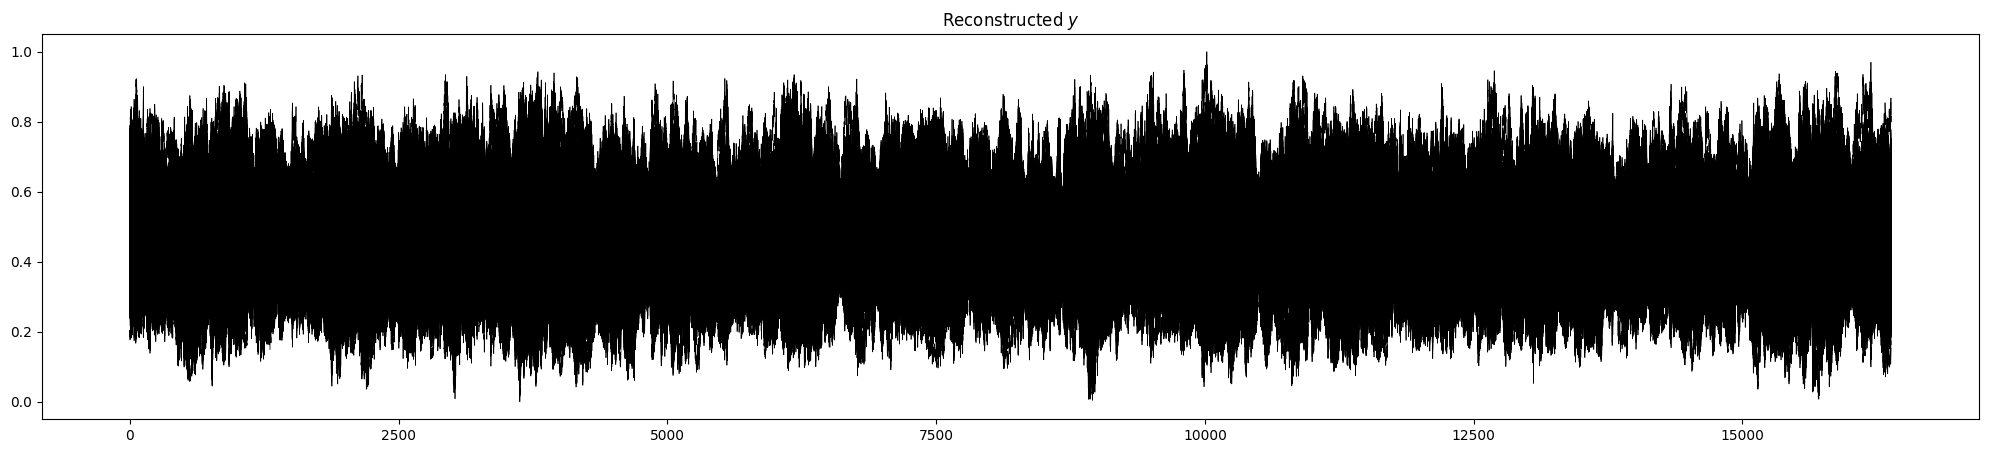

In [204]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


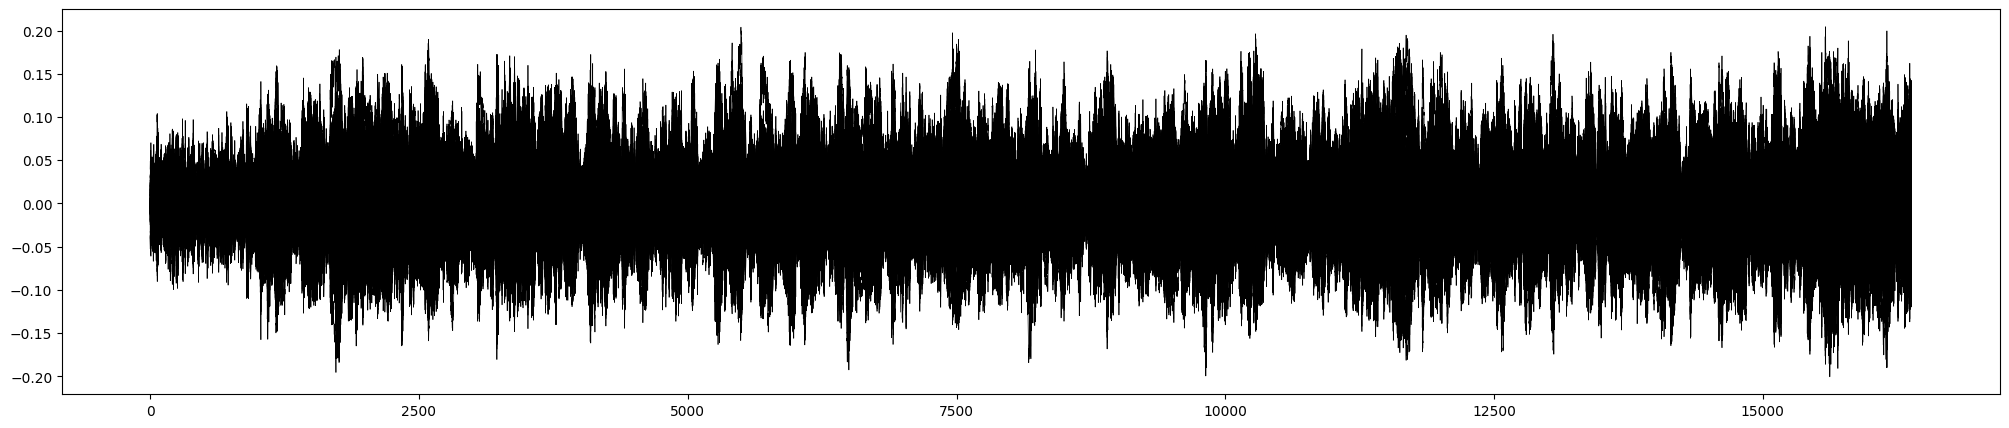

In [205]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

### Factor estimation

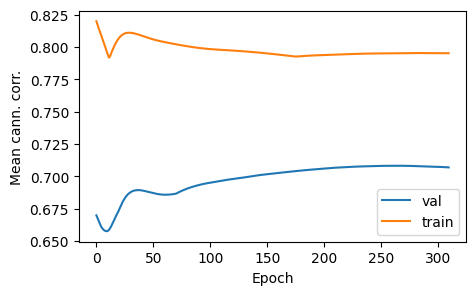

In [476]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'], label='val')
plt.plot(train_hist['train_CCA_mean_corr'], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

In [477]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  
print("cc R2 on test data: ", cca.score(f_test_hat, f_test))  

from evaluation import bootstrapCCA
#bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=1000)
print("Bootstrapped cca: mean, std, 95%ci", (np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975])))

y_test_hat = mod(torch.Tensor(y_test).float()).detach().numpy()
print(f'Mse on test data: {np.mean((y_test_hat - y_test)**2)}')





cc on train data: 0.7951726434425493
cc on test data: 0.6500181230277166
cc on train data:  0.7951725172145044


/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


cc on test data:  0.6500180225227352
cc R2 on test data:  0.1887889441278067
Bootstrapped cca: mean, std, 95%ci (0.22090489998409485, 0.008297475035107284, array([0.20464246, 0.2372057 ]))
Mse on test data: 0.08671577274799347


0.2196970413392184 0.008327656636502999 [0.20347564 0.23639581]


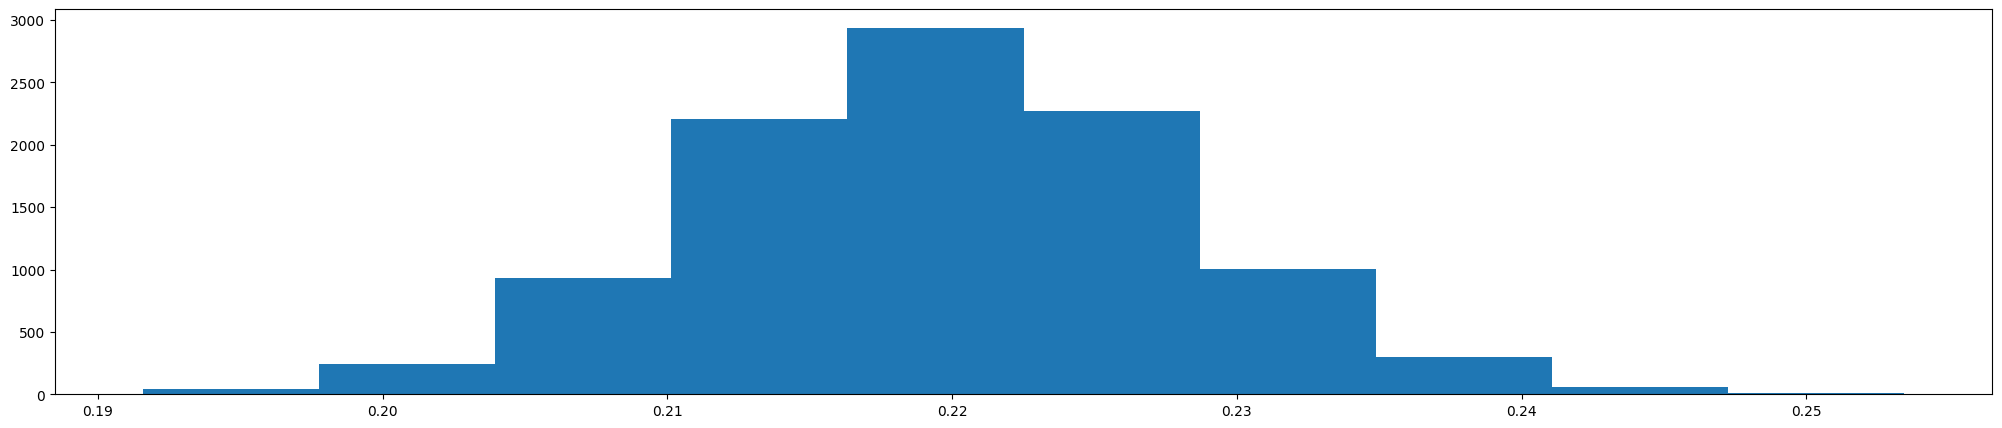

In [188]:
from evaluation import bootstrapCCA
bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=1000)
print(np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975]))
plt.hist(bs);

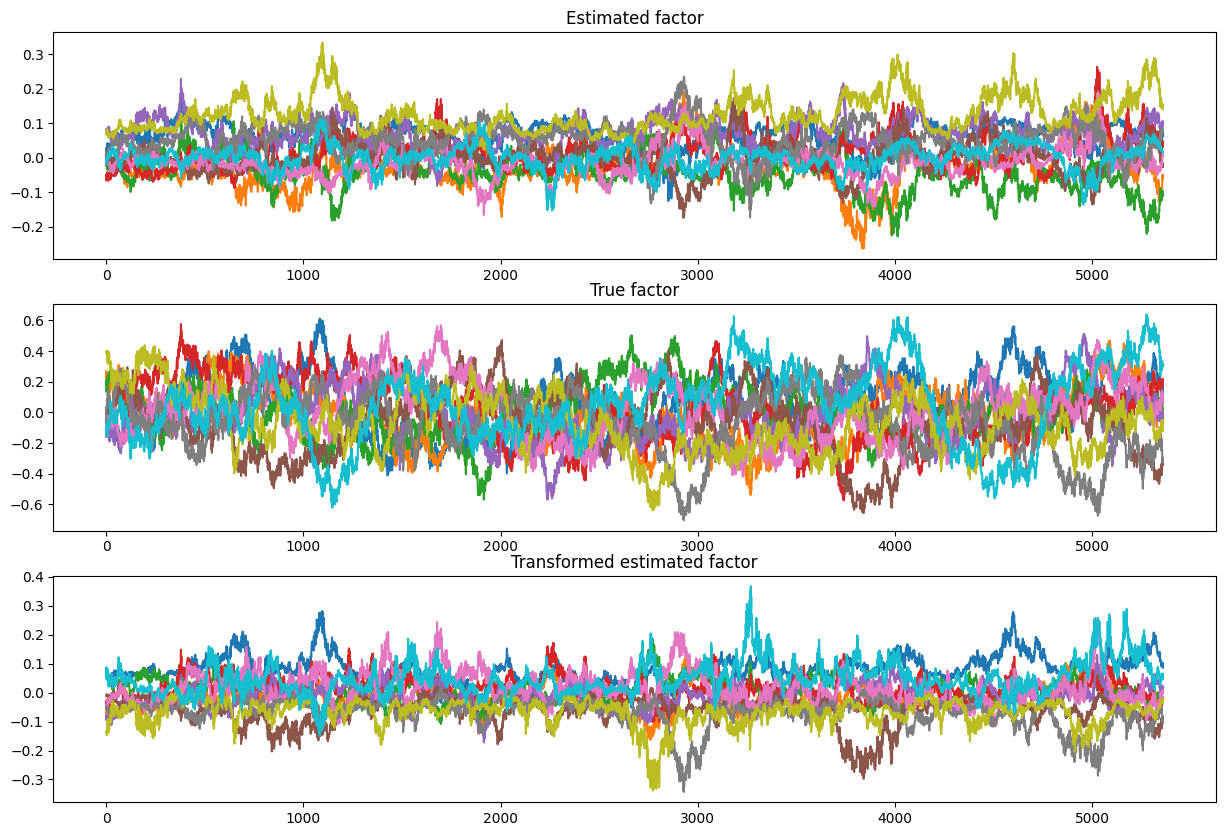

In [350]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

In [213]:
y_test.shape

(14360, 100)

In [211]:
y_test_pred.shape

(7168, 100)

In [212]:
y_test_pred - y_test

ValueError: operands could not be broadcast together with shapes (7168,100) (14360,100) 

### Forecast

1-step ahead  FMSE on the test set: 0.001349356789612164


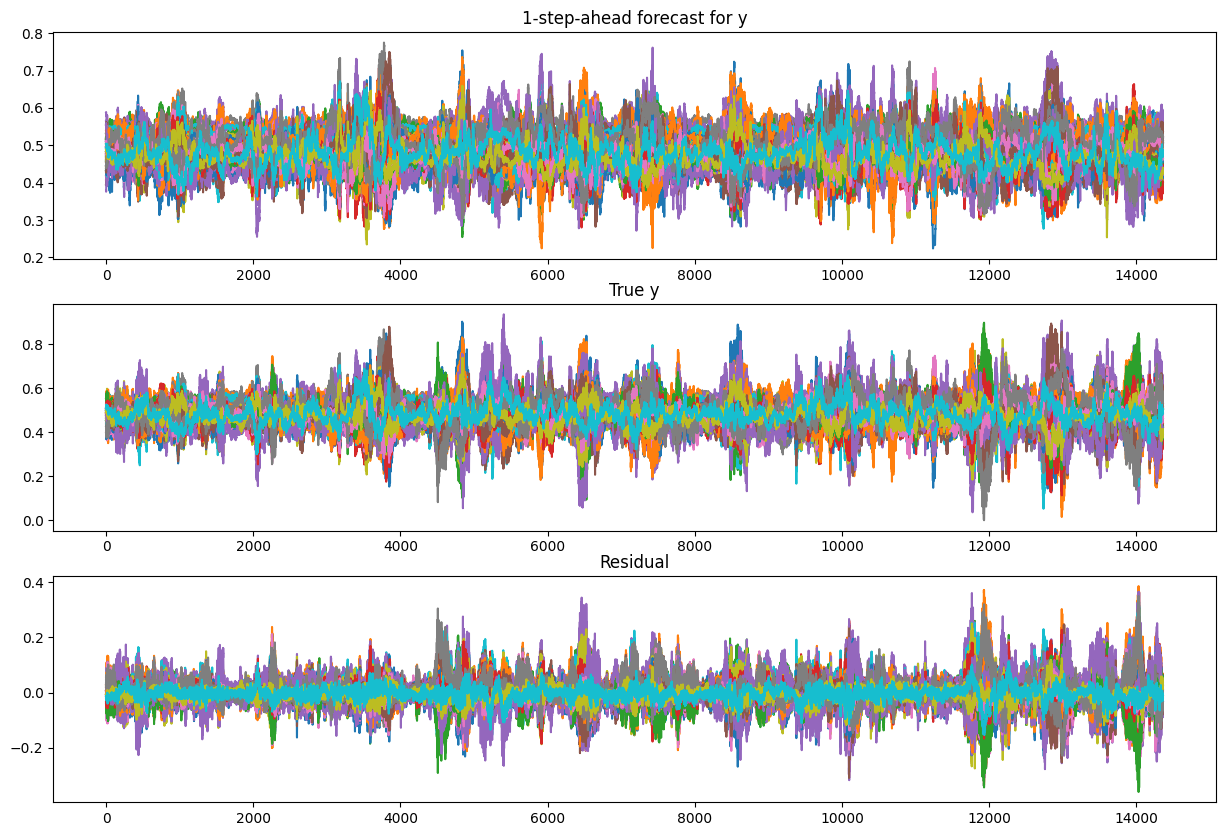

In [342]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
#f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_train_hat, f_val_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[cfg.T_train + cfg.T_val - 2:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

1-step ahead  FMSE on the test set: 0.001120314234867692


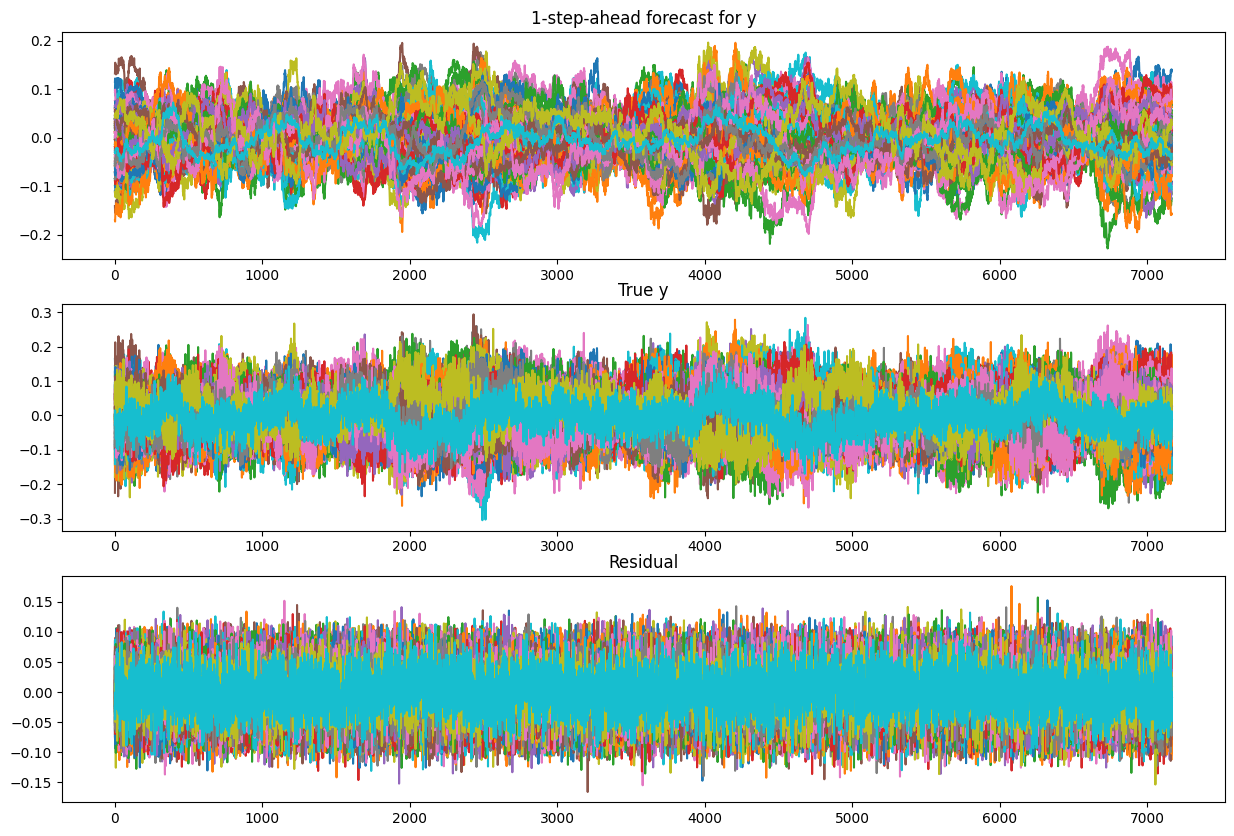

In [ ]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

In [ ]:
from dm import in_MDM_test
e1 = np.sum(y_test_pred[0:200]-y_test[0:200],axis=1)
e2 = np.sum(y_test_pred[200:400]-y_test[200:400],axis=1)
d = np.vstack([e1,e2])
in_MDM_test(d, q=3, statistic='Sc')


[array([-4.83519267, -0.88930998]),
 {'statistic': array([[24.69429677]]),
  'parameter': 3,
  'alternative': 'Equal predictive accuracy does not hold.',
  'p.value': array([[4.34211768e-06]]),
  'method': 'multivariate Diebold-Mariano test',
  'data.name': '[[ 4.79529500e-01 -9.63633358e-02  1.78181291e-01  1.16548568e-01\n   1.31618828e-01 -4.70486283e-02 -4.49910820e-01 -3.44798893e-01\n  -5.85365057e-01 -1.58060282e-01  3.49326044e-01  2.09747851e-01\n  -5.88828027e-02  7.58422166e-02  7.17078984e-01  5.64274907e-01\n   8.31719577e-01 -4.11872178e-01  2.06792831e-01  2.98056751e-02\n   1.44059241e-01  5.46021879e-01 -1.76732197e-01 -5.81284016e-02\n  -7.22203672e-01 -7.15541005e-01 -9.72125113e-01 -5.39268851e-01\n  -2.25835085e-01 -3.37127507e-01 -2.69950330e-01 -8.04915190e-01\n  -2.16774508e-01  9.71347690e-02  9.16699469e-02 -4.30077851e-01\n  -1.27607846e+00 -8.94060969e-01  4.18439329e-01  2.32095599e-01\n  -2.89919317e-01 -1.82350159e-01  3.39898407e-01 -3.65081489e-01\n  -5

In [ ]:
a = np.array([1,2,3,4,5,6,7,1,2,3,4,5,6,7])
b = np.array([1,0,0,0,0,2,0,0,0,1,0,0,0,0])
realized =  np.array([2,2,2,2,2,2,2,2,2,2,2,2,2,2])
d = np.stack([(a-realized)**2, (b-realized)**2])
q = 3
in_MDM_test(d, q=3, statistic='Sc')


[array([2.20895601, 0.85136117]),
 {'statistic': array([[2.82956626]]),
  'parameter': 3,
  'alternative': 'Equal predictive accuracy does not hold.',
  'p.value': array([[0.2429783]]),
  'method': 'multivariate Diebold-Mariano test',
  'data.name': '[[ 1  0  1  4  9 16 25  1  0  1  4  9 16 25]\n [ 1  4  4  4  4  0  4  4  4  1  4  4  4  4]]'}]

In [ ]:
np.sum(y_test_pred-y_test,axis=1).shape

(7168,)

In [ ]:
y_test_pred[0:300].shape

(300, 100)

In [ ]:
np.concatenate([y_val,y_test][0:100]).shape

(8192, 100)

In [ ]:
from evaluation import expandingWindowForecast
ewf = expandingWindowForecast(mod=mod,y_train = y_train, y_test = np.concatenate([y_val,y_test])[0:20])

(1, 100)
(8193, 100) (19, 100)
(1, 100)
(8194, 100) (18, 100)
(1, 100)
(8195, 100) (17, 100)
(1, 100)
(8196, 100) (16, 100)
(1, 100)
(8197, 100) (15, 100)
(1, 100)
(8198, 100) (14, 100)
(1, 100)
(8199, 100) (13, 100)
(1, 100)
(8200, 100) (12, 100)
(1, 100)
(8201, 100) (11, 100)
(1, 100)
(8202, 100) (10, 100)
(1, 100)
(8203, 100) (9, 100)
(1, 100)
(8204, 100) (8, 100)
(1, 100)
(8205, 100) (7, 100)
(1, 100)
(8206, 100) (6, 100)
(1, 100)
(8207, 100) (5, 100)
(1, 100)
(8208, 100) (4, 100)
(1, 100)
(8209, 100) (3, 100)
(1, 100)
(8210, 100) (2, 100)
(1, 100)
(8211, 100) (1, 100)
(1, 100)
(8212, 100) (0, 100)


In [ ]:
np.mean(ewf,axis=1).shape

(20, 100)

In [ ]:
ewf[0].shape

(1, 100)

In [ ]:
np.vstack(ewf).shape

(20, 100)

(100,)


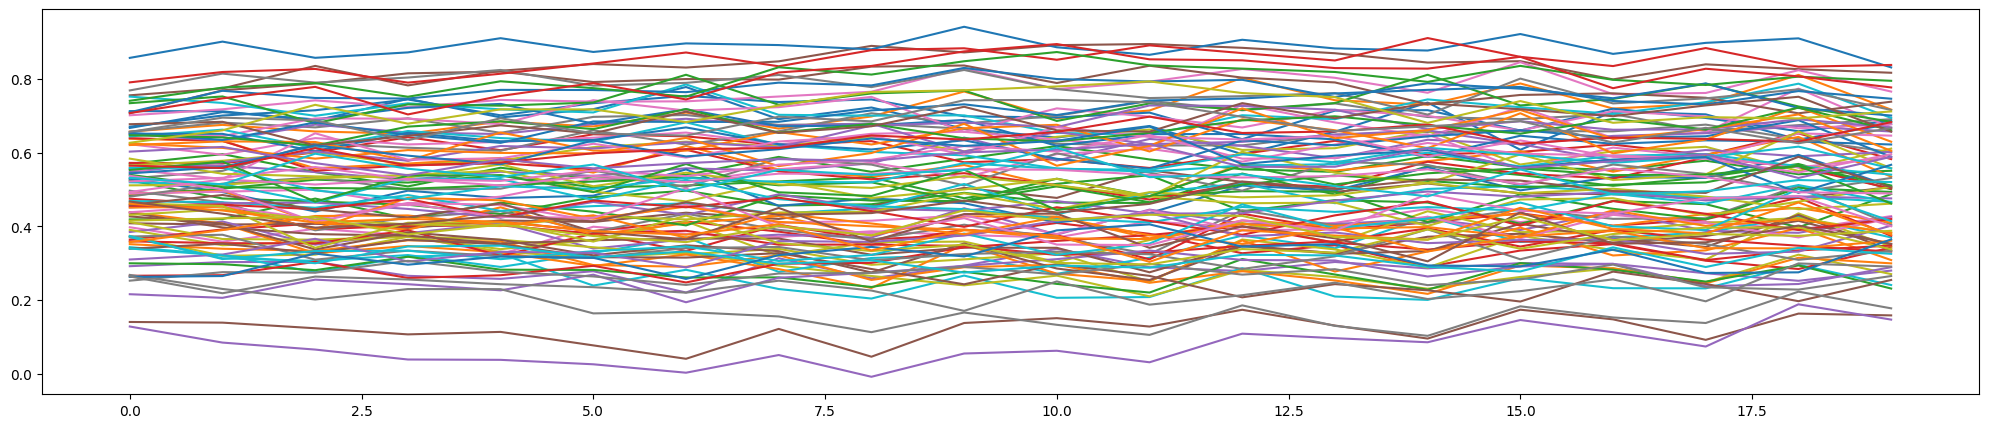

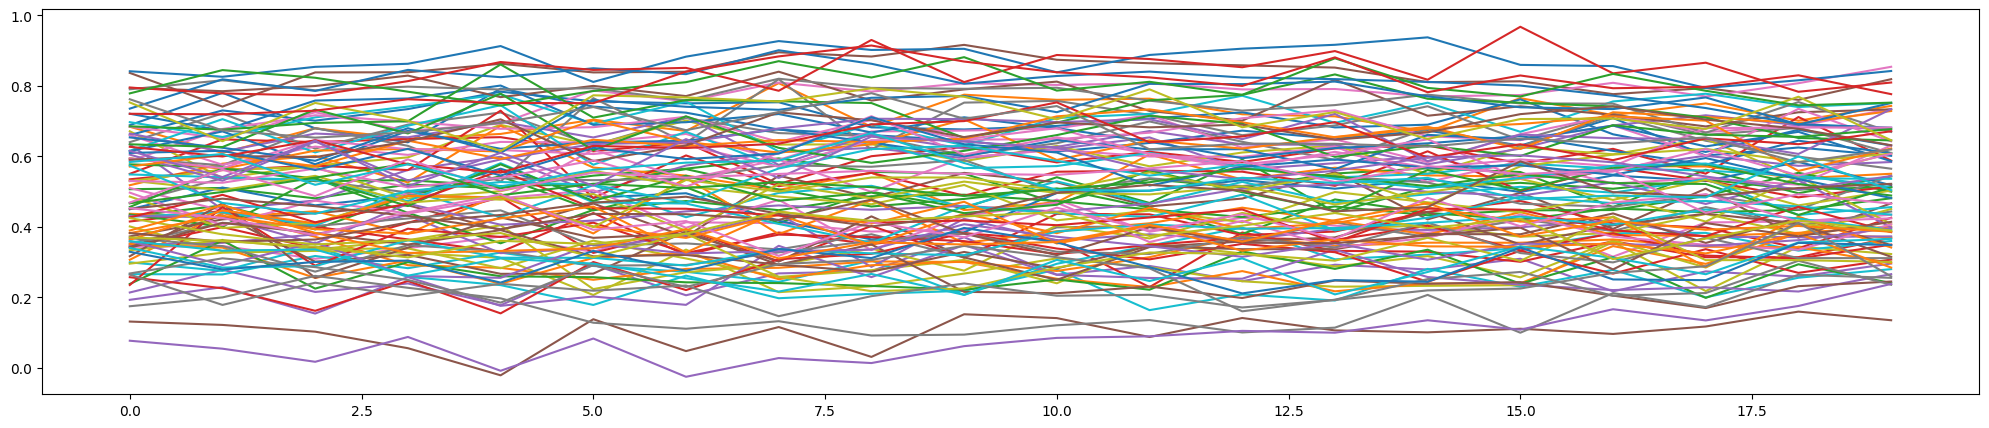

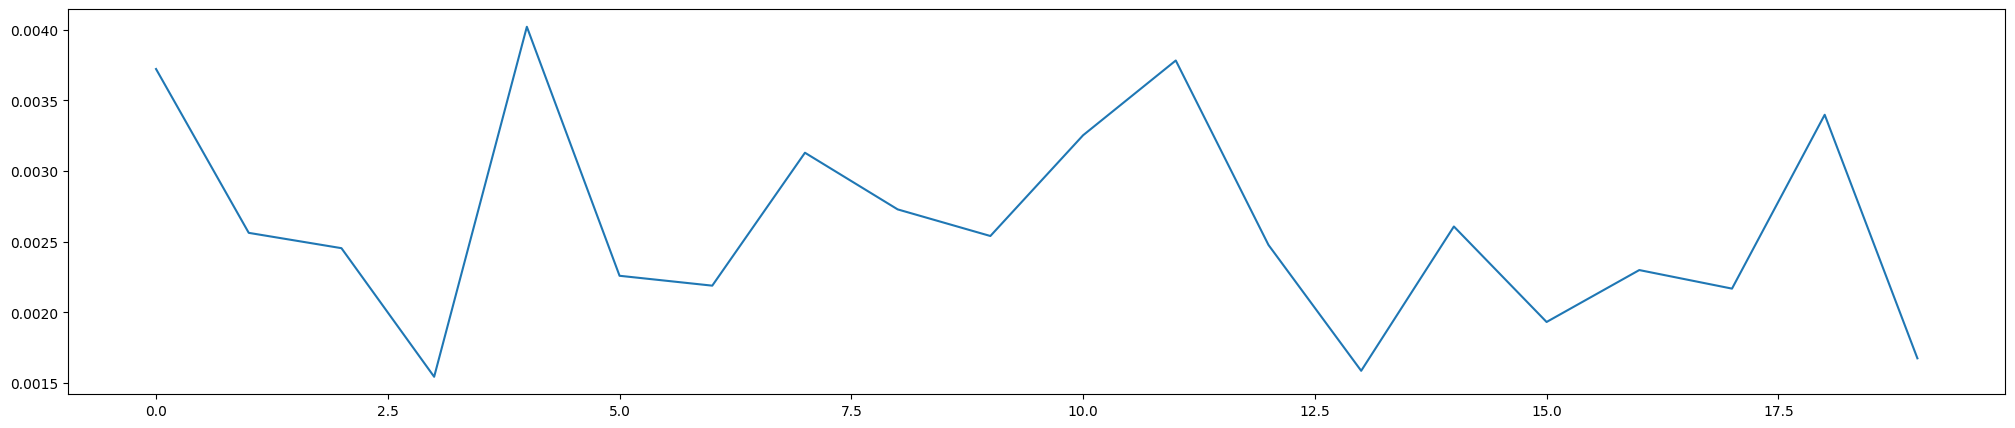

In [ ]:
plt.plot(ewf);
plt.figure()
plt.plot(np.concatenate([y_val,y_test])[0:20]);
print(np.mean(ewf - np.concatenate([y_val,y_test])[0:20], axis=0).shape)
plt.figure()
plt.plot(np.mean((ewf - np.concatenate([y_val,y_test])[0:20])**2, axis=1))